In this notebook, we're going to talk about how we can manipulate and extract information from images using a sliding window.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -Ncnp https://images.fineartamerica.com/images-medium-large-5/coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg

--2024-06-26 23:38:34--  https://images.fineartamerica.com/images-medium-large-5/coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 65.8.243.30, 65.8.243.68, 65.8.243.63, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|65.8.243.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278914 (272K) [image/jpeg]
Saving to: ‘coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg’

coloured-mri-scan-o 100%[===================>] 272.38K  --.-KB/s    in 0.04s   

2024-06-26 23:38:35 (6.32 MB/s) - ‘coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg’ saved [278914/278914]



In [3]:
import shutil
import os
orig_file = os.path.join('coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg')

os.rename(orig_file, 'color_mri.jpg')

# Sliding Windows with Images

When we talked about time-series data, we discussed the importance of using a sliding window to break down a sequence into smaller, more managable chunks. The sliding window had a width and stride that were both measured in time.

It turns out that similar considerations hold true for images. When we view a picture of a person's face, it feels like we recognize it as a face in an instant. However, our mind actually goes through the following process to reach within fractions of a second:
* We see edges and smooth regions
* Those visual features combine into corners
* Those visual features combine into shapes (e.g., eyes and mouth)
* Those visual features combine into an entire face

In other words, we see visual features in small subregions of the image, and then we combine those visual features in our head to get a high-level understanding of the entire image.

With image data, a sliding window is defined by its height, width, and stride in both directions. All of these parameters are measured in pixels.

Sliding windows are often square in order to treat the height and width dimensions the same, so we really only care about the same two dimensions as before: window width and window stride.

Play around with the animation below to see how a sliding window moves across an image:

In [4]:
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

def show_animated_window(img, width, stride):
    # Calculate bounds
    h, w, _ = img.shape

    # Create the figure and show the image
    fig, ax = plt.subplots(figsize=(5, 3))
    _ = ax.imshow(img)

    # Create the animated box and add it to the graph
    box = plt.Rectangle((0, 0), width, width,
                        fill=True, color='orange', alpha=0.5)
    ax.add_patch(box)

    # Calculate and update the new box position
    def update(frame):
        max_windows_horiz = (w-width) // stride + 1
        max_windows_vert = (h-width) // stride
        new_x = (frame % max_windows_horiz) * stride
        new_y = frame // max_windows_horiz * stride
        box.set_x(new_x)
        box.set_y(new_y)
        return [box]

    # Create the animation
    num_windows = 20
    anim = animation.FuncAnimation(fig, update, frames=range(num_windows), interval=1000)
    return anim

In [21]:
window_width = 100 #@param {name:"test", type:"slider", min:25, max:100, step:25}
window_stride = 100 #@param {name:"test", type:"slider", min:25, max:100, step:25}

img = cv2.imread('color_mri.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_animated_window(img, window_width, window_stride)

Output hidden; open in https://colab.research.google.com to view.

# Image Kernels

An ***image kernel*** is a special kind of sliding window with a stride of 1 that applies a mathematical operation at every location of an image. The mathematical operation, called a ***convolution***, depends on the contents of an array that is the same size as the sliding window.

The pseudocode for doing convolution with an image kernel is as follows:
```
initialize an empty image to store results

for each position of the sliding window:
   grab the subregion that is overlapped by the window
   compute the element-wise product between the kernel and the subregion
   compute the sum of those values
   put that sum in the result image at the middle of the window
```

The animation below illustrates this process. Notice that in order to get a value for every pixel in the result image, the sliding window needs to move outside of the bounary of the image where there are no values. There are various strategies that get used to address this boundary issue. In this particular animation, the values at the boundaries are simply repeated.

<img src="https://drive.google.com/uc?id=1Sey_Uj3Oxn1u4WZoFVoOJfp8dH-_I8cH" width=300px/>

The function for applying a kernel to an image is `cv2.filter2D()`. This function takes the following parameters:
* **img**: The image we want to process
* **ddepth**: The depth of the resulting image in terms of number of channels and data format (e.g., `uint8`). Using `-1` will preserve the characteristics of the original image, applying the kernel to each color channel independently.
* **kernel**: The 2D `numpy` array that defines the values in your kernel.

The function below will allow us to apply a kernel on an image (we will look at a colored MRI) and compare the results before and after the transformation.

In [6]:
# Load the image
img = cv2.imread('color_mri.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def apply_kernel(kernel, img_pre=img, img_post=None):
    """
    kernel: the kernel that we would like to apply to the image
    img_pre: the pre-kernel image if we generated it elsewhere
    img_post: the post-kernel image if we generated it elsewhere
    """
    if img_post is None:
        # Apply the kernel
        img_post = cv2.filter2D(img, ddepth=-1, kernel=kernel)

    # Display the results
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1), plt.imshow(img_pre, cmap='gray'), plt.title('Pre-Kernel')
    plt.subplot(1, 2, 2), plt.imshow(img_post, cmap='gray'), plt.title('Post-Kernel')
    plt.show()

In the following sections, we will discuss different kinds of kernels and their utility.

# Identity Kernel

A 3 $\times$ 3 identity kernel has the following structure:

$
\begin{bmatrix}
	0 & 0 & 0 \\
	0 & 1 & 0 \\
	0 & 0 & 0 \\
\end{bmatrix}
$

As we increase the kernel size to a size $k$, all of the values remain 0 except for the value in the absolute center.

So what happens when we apply this filter to an image? The sum we put at each position of the result image is simply the value of the pixel in the middle of the kernel in the original image. Therefore, this identity kernel does nothing!

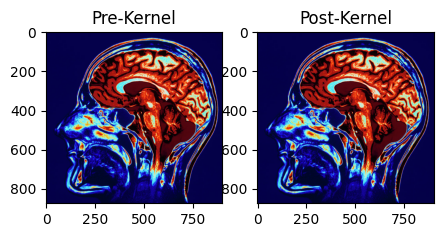

In [8]:
kernel_size = 15 #@param {type:"slider", min:3, max:21, step:2}

identity_kernel = np.zeros((kernel_size, kernel_size))
identity_kernel[int(kernel_size/2), int(kernel_size/2)] = 1
apply_kernel(identity_kernel)

# Box Blur

A 3 $\times$ 3 box kernel has the following structure:

$\frac{1}{9}
\begin{bmatrix}
	1 & 1 & 1 \\
	1 & 1 & 1 \\
	1 & 1 & 1 \\
\end{bmatrix}
$

As we increase the kernel size to a size $k$, all of the values remain 1, but the fraction multiplied at the beginning changes so that it is $\frac{1}{k^2}$ .

By summing the values within the sliding window and then dividing by the quantity of numbers in the sum, we are calculating the average pixel value at that position. Like a moving average, this causes the image to become more blurred. The larger the kernel, the more significant the blurring.

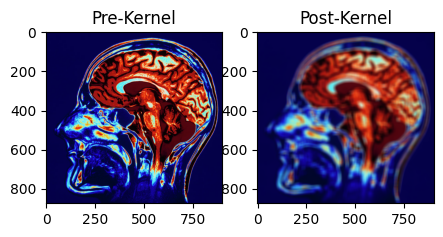

In [10]:
kernel_size = 21 #@param {type:"slider", min:3, max:21, step:2}

box_kernel = (1/kernel_size**2)*np.ones((kernel_size, kernel_size))
apply_kernel(box_kernel)

# Gaussian Blur Kernel

A 3 $\times$ 3 Gaussian blur kernel has the following structure:

$\frac{1}{16}
\begin{bmatrix}
	1 & 2 & 1 \\
	2 & 4 & 2 \\
	1 & 2 & 1 \\
\end{bmatrix}
$

As we increase the kernel size to a size $k$, the values follow the equation for a 2D Gaussian curve:

$f(x,y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$

where $\sigma$ is the standard deviation along both dimensions.

This kernel is similar to the box kernel in that we are taking a weighted average of all the values in the image. However, greater importance is given to the values in the middle, and less importance is given to the values in the periphery.

Calculating this kernel can be a bit of a pain. Fortunately, `opencv` provides a function called `cv2.GaussianBlur()` that automatically computes the kernel and applies it on our image:

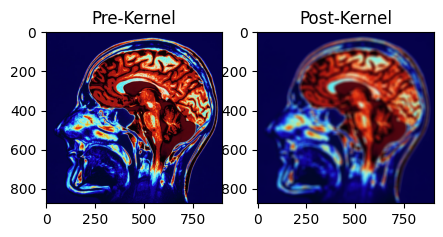

In [12]:
kernel_size = 21 #@param {type:"slider", min:3, max:21, step:2}

img = cv2.imread('color_mri.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
blur_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigmaX=10)

apply_kernel(None, img_post=blur_img)

# Unidirectional Edge Detection Kernel

There are a couple different formulations for edge detection kernels. We will focus on a class of kernels called ***Sobel operators***. A 3 $\times$ 3 Sobel operator for vertical edge detection has the following structure:

$
\begin{bmatrix}
	-1 & 0 & 1 \\
	-2 & 0 & 2 \\
	-1 & 0 & 1 \\
\end{bmatrix}
$

This is the first time we've seen a kernel with a negative value. By having a mix of negative and positive values, we are taking the difference between values on opposite sides of the kernel, which essentially serves as a form of comparison. Mathematically, the Sobel operator approximates a derivative, or ***gradient***, in the direction opposite of the edges we are trying to detect. In this case, we are trying to find locations with large horizontal gradients in order to detect vertical edges.


The table below enumerates the possible combinations that the kernel might encounter:

| Left Side | Right Side | Convolution Result |
|:--------------:|:-----------:|:-----------:|
| Low values (dark) | Low values (dark) | Close to zero (no edge) |
| Low values (dark) | High values (bright) | Very positive (edge) |
| High values (bright) |Low values (dark) | Very negative (edge) |
| High values (bright) | High values (bright) |  Close to zero (no edge) |

Similar to the Gaussian blur kernel, `opencv` provides a function for the Sobel operator called `cv2.Sobel()` that allows us to create multiple kinds of Sobel operators. Let's start with the vertical edge detector:

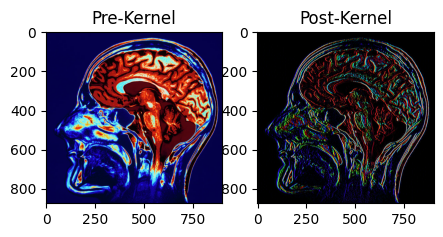

In [13]:
kernel_size = 3 #@param {type:"slider", min:3, max:7, step:2}

vert_img = cv2.Sobel(img, ddepth=-1,
                     dx=1, dy=0, ksize=kernel_size)

apply_kernel(None, img_post=vert_img)

Notice that this image is quite colorful. That's because we're applying this kernel to all three color channels separately and then combining the result. Let's apply this kernel to a grayscale image so that it's easier to interpret:

In [ ]:
kernel_size = 3 #@param {type:"slider", min:3, max:7, step:2}

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx_img = cv2.Sobel(gray_img, ddepth=-1,
                       dx=1, dy=0, ksize=kernel_size)

apply_kernel(None, img_pre=gray_img, img_post=sobelx_img)

Let's touch on the key observations:
* The output is black wherever the original image was smooth
* Along the right side of the head in particular, we can see prominent lines corresponding to edges.
* Along the chin and the top of the head, the lines are not as prominent.

Most of the edges in this image are not strictly horizontal or vertical. However, some are more vertical than others and vice versa. The more vertical the edge in the image, the more intense the color will be in that region after the Sobel operator.

The Sobel operator for horizontal edge detection takes a similar structure:

$
\begin{bmatrix}
	1 & 2 & 1 \\
	0 & 0 & 0 \\
	-1 & -2 & -1 \\
\end{bmatrix}
$

And we can see how these results are similar to the ones we had with the vertical operator, only that the horizontal edges are highlighted more.

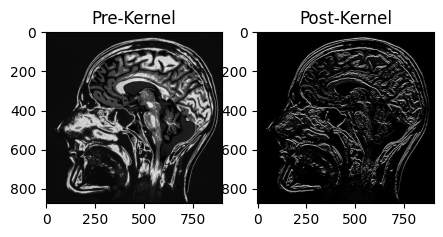

In [14]:
kernel_size = 3 #@param {type:"slider", min:3, max:7, step:2}

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobely_img = cv2.Sobel(gray_img, ddepth=-1,
                       dx=0, dy=1, ksize=kernel_size)

apply_kernel(None, img_pre=gray_img, img_post=sobely_img)

There is a catch to the Sobel operator. Recall that the numbers in our image are stored as `uint8`, which stands for *unsigned* integers. Depending on whether the edge is going from black-to-white or white-to-black, one of the directions is going lead to negative number after the convolution. The way around this is by casting your array to a signed data type (e.g., signed 16-bit). However, we're going to forgo this exercise since there are better ways of finding edges.

# Omnidirectional Edge Detection Kernel

Chances are that you will want to detect edges along both directions at the same time. One way you can do this is by combining the results from the horizontal $S_x$ and vertical ($S_y$) Sobel operators as follows:

$S_{mag} = \sqrt{S_x^2 + S_y^2}$

$S_{angle} = \arctan(\frac{S_y}{S_x})$

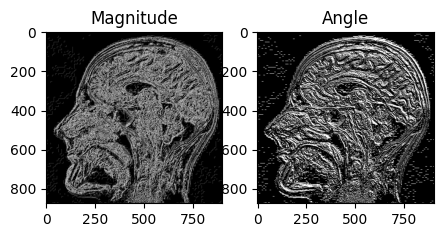

In [15]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply the Sobel kernels
sobelx_img = cv2.Sobel(gray_img, ddepth=-1,
                       dx=1, dy=0, ksize=3)
sobely_img = cv2.Sobel(gray_img, ddepth=-1,
                       dx=0, dy=1, ksize=3)

# Calculate the magnitude and the direction
sobel_img_mag = np.sqrt(sobelx_img**2 + sobely_img**2)
sobel_img_dir = np.arctan2(sobely_img, sobelx_img)

# Show the results
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1), plt.imshow(sobel_img_mag, cmap='gray'), plt.title('Magnitude')
plt.subplot(1, 2, 2), plt.imshow(sobel_img_dir, cmap='gray'), plt.title('Angle')
plt.show()

However, the quicker way of finding edges in multiple directions is by using a ***Laplacian operator***. As a 3 $\times$ 3 kernel, the Laplacian operator has the following structure:

$
\begin{bmatrix}
	0 & 1 & 0 \\
	1 & -4 & 1 \\
	0 & 1 & 0 \\
\end{bmatrix}
$

We can use the function `cv2.Laplacian()` as follows:

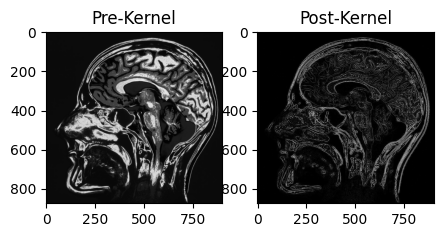

In [16]:
kernel_size = 3 #@param {type:"slider", min:3, max:7, step:2}

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
laplace_img = cv2.Laplacian(gray_img, ddepth=-1,
                            ksize=kernel_size)

apply_kernel(None, img_pre=gray_img, img_post=laplace_img)

# Sharpening Kernel

The last kernel we will cover is a 3 $\times$ 3 sharpening kernel, which takes the following structure:

$
\begin{bmatrix}
	0 & -1 & 0 \\
	-1 & 5 & -1 \\
	0 & -1 & 0 \\
\end{bmatrix}
$

Similar to our Laplacian operator, this kernel produces high values whenever there are major differences between the middle point and those that surround it. However, this kernel emphasizes points whenver they have a significantly different value from those that surround it, causing it to enhance the edges that appear in the image.

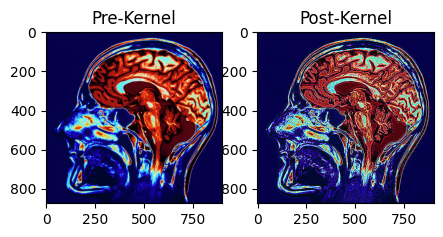

In [18]:
kernel_size = 9 #@param {type:"slider", min:3, max:21, step:2}

sharpen_kernel = np.zeros((kernel_size, kernel_size))
sharpen_kernel[int(kernel_size/2), :] = -1
sharpen_kernel[:, int(kernel_size/2)] = -1
sharpen_kernel[int(kernel_size/2), int(kernel_size/2)] = (kernel_size-1)*2+1

apply_kernel(sharpen_kernel)

# A Precursor to Deep Learning

Although we have yet to extract useful summary data from our images, understanding kernels and convolutions is vital to understanding a slew of concepts you will encounter in digital signal processing and machine learning.

The diagram below illustrates the architecture of a convolutional neural network (CNN) — the structure that many deep learning models rely upon to work with image data.

<img src="https://drive.google.com/uc?id=1aYq_6S6Plf2NFlFipAYdZbcuv00Z9jUe" width=500px/>

The first stage of the model (on the left), passes a series of kernels along the input image and produces a series of new images that encode different characteristics of the input. The second stage repeats the same process, but the input to this process is now the output from the previous stage. As the model goes through multiple stages, it is gradually able to combine features across the entire image, similar to how we need to see eyes and mouths before we can identify faces.